In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Of Datasets

We have 3 files - train, test, sample. I am going to extract the HR column of the sample file which will be used as y_true for out test data. 

In [17]:
train=pd.read_csv('train_data.csv')

In [18]:
test=pd.read_csv("sample_test_data.csv")

In [19]:
test['condition'].value_counts()

condition
interruption     5
no stress        3
time pressure    2
Name: count, dtype: int64

In [20]:
sample=pd.read_csv('sample_output_generated.csv')

In [21]:
y_true=sample['HR']

# Explotary Data Analysis

***Checking of Datatype and Missing values***

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uuid               5000 non-null   object 
 1   VLF                5000 non-null   float64
 2   VLF_PCT            5000 non-null   float64
 3   LF                 5000 non-null   float64
 4   LF_PCT             5000 non-null   float64
 5   LF_NU              5000 non-null   float64
 6   HF                 5000 non-null   float64
 7   HF_PCT             5000 non-null   float64
 8   HF_NU              5000 non-null   float64
 9   TP                 5000 non-null   float64
 10  LF_HF              5000 non-null   float64
 11  HF_LF              5000 non-null   float64
 12  SD1                5000 non-null   float64
 13  SD2                5000 non-null   float64
 14  sampen             5000 non-null   float64
 15  higuci             5000 non-null   float64
 16  datasetId          5000 

There are 2 object type columns and the target column is continous , therefore it is a linear regression problem. Also there is not missing values in the dataset.
we will drop the uuid column , there is no use of it. 

In [23]:
for columns in train.columns:
    print(train[columns].value_counts())

uuid
4a122afe-6e52-4ed0-840d-66155da95ba1    1
5c73067a-a486-467a-afb0-e26c68f11eff    1
5e4c344d-83d6-4add-85ee-57fad9320064    1
9f81146e-7ecf-4b9f-80c5-8245a99f9077    1
bcf15d1b-e906-4a80-9059-760057d0617b    1
                                       ..
5968f6b5-a36b-448d-8cd8-bb31301d5832    1
ef1d4653-8905-4f19-b340-cb16baafb216    1
caa8fd66-e137-4862-8c5f-6f52994815ad    1
44a8b6b7-1b75-4c82-b6ef-fce9b445868b    1
10342ad1-fa6f-42de-b9ca-28c0ae1e8f4d    1
Name: count, Length: 5000, dtype: int64
VLF
2259.833995    1
2251.703105    1
1984.534143    1
8037.905731    1
4845.592926    1
              ..
1628.269553    1
1067.052194    1
2522.206052    1
820.289766     1
948.733194     1
Name: count, Length: 5000, dtype: int64
VLF_PCT
67.884986    1
48.704661    1
56.396907    1
85.112073    1
78.996277    1
            ..
70.010764    1
72.134914    1
88.828159    1
55.245731    1
25.972073    1
Name: count, Length: 5000, dtype: int64
LF
1058.573968    1
2368.177329    1
1513.330433 

From the above value_counts you can understand that datasetId column is a constant column wich is equal to 2. So we will drop it.

In [24]:
df=train.drop(['datasetId','uuid'],axis=1)
y=train['HR']

In [25]:
test1=test.drop(['datasetId','uuid'],axis=1)

I am also droping the uuid column which is just a ID column.

We have also a object column called condition , I am going to convert that column to numerical column by using a %allocation method. I am going to use the formula like 

= (Count of that value)/(total values in that column)

In [26]:
train['condition'].value_counts()
df['condition']=train['condition'].map({'no stress':0.5418,'interruption':0.2774,'time pressure':0.1808}) # check this

In [27]:
total_counts=test1['condition'].count()
count=test1['condition'].value_counts()
test1['condition']=test1['condition'].map(lambda x:count[x]/total_counts)

In [28]:
def condition_mapping_function(x):
    return count[x] / total_counts

In [29]:
df.shape

(5000, 35)

We can see that the target column here is continous, so this is a regression problem , there are many ML algorithms to solve it , like Linear Regression, DecisionTree Regression, RandomForest Regression , Support Vector Regression. Lets analyze each of them.

First we are removing highly correlated data columns

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: ylabel='HR'>

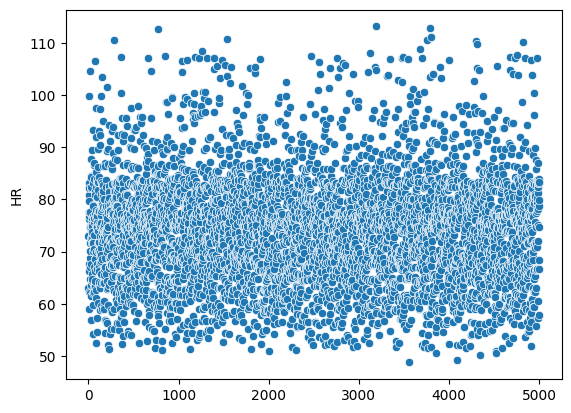

In [31]:
sns.scatterplot(y)

The most of the values of the heart-rates are gathered within the 55-85.

In [32]:
corr=df.corr()

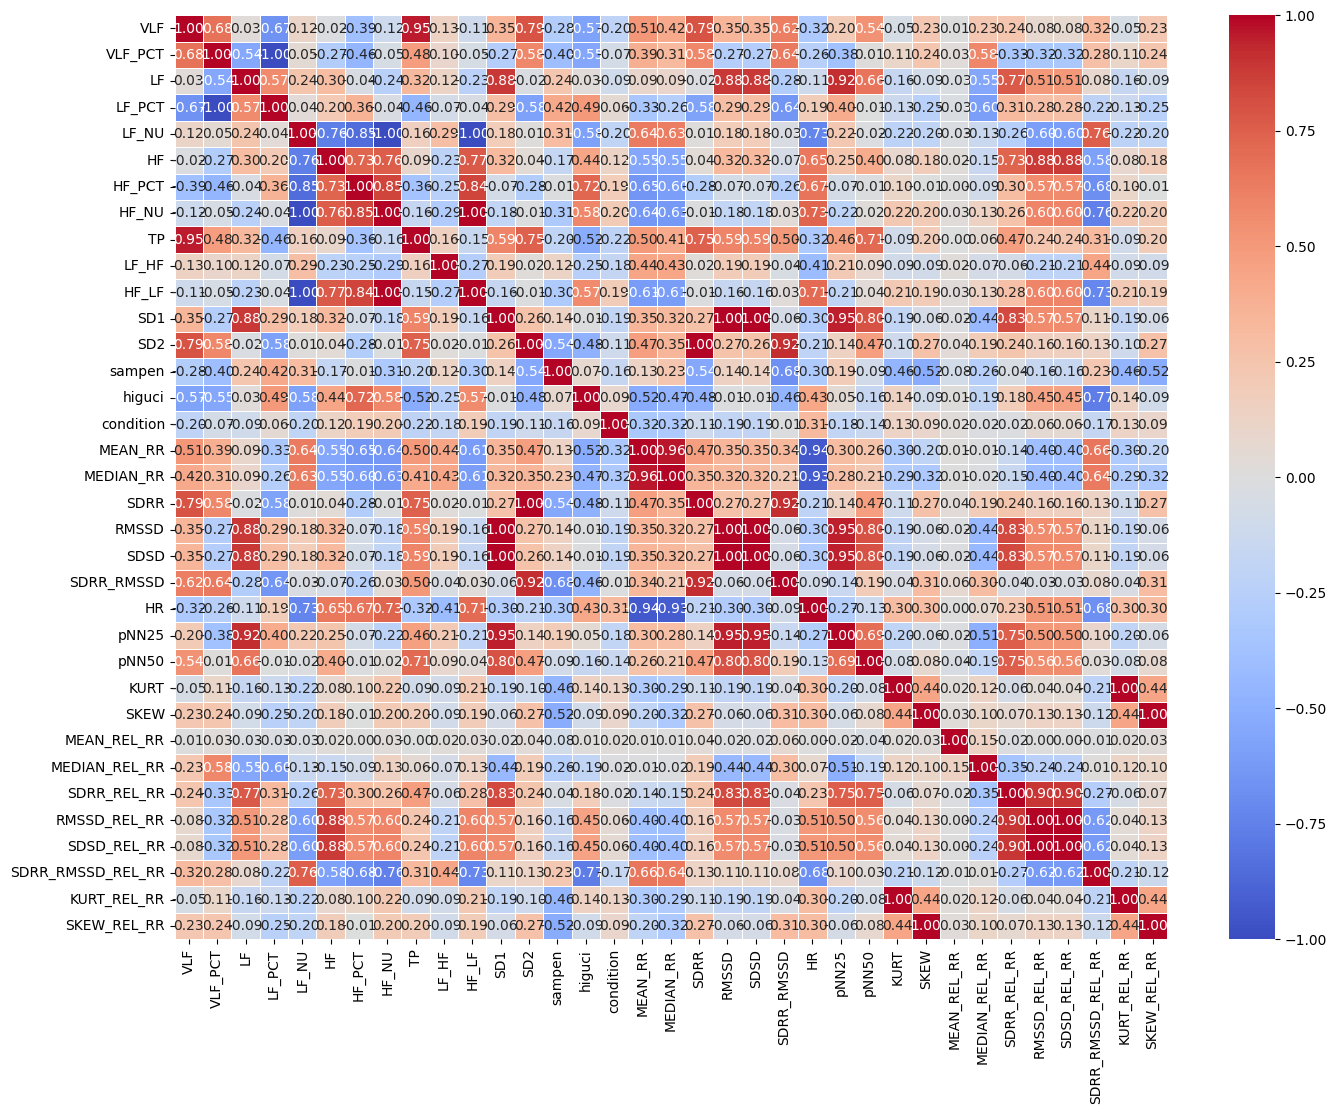

In [33]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

In [34]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8: # hyperparameter-1
            if columns[j]:
                columns[j] = False

In [ ]:
selected_columns = df.columns[columns]
selected_columns

(20,)

In [36]:
df_new=df[selected_columns]


In [37]:
df_new.columns

Index(['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'LF_HF',
       'SD2', 'sampen', 'higuci', 'condition', 'MEAN_RR', 'HR', 'pNN50',
       'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_RMSSD_REL_RR'],
      dtype='object')

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


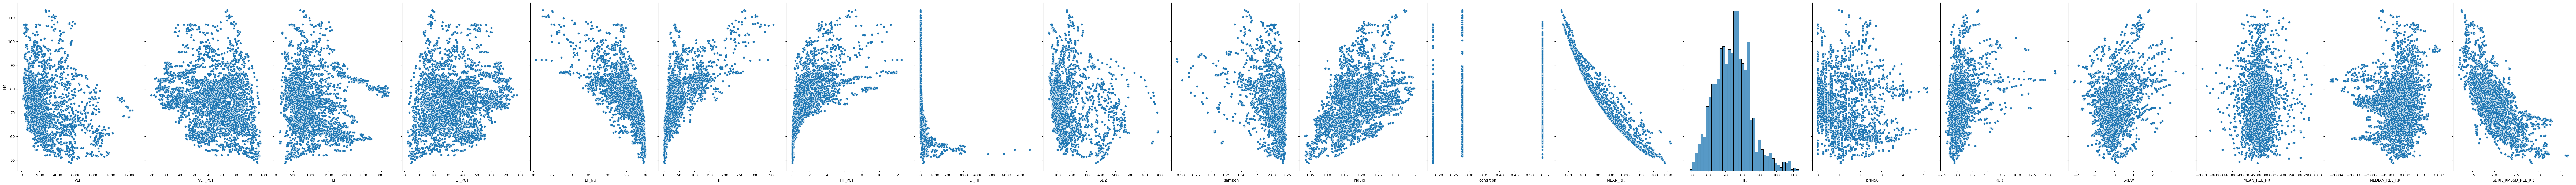

In [38]:
sns.pairplot( df_new,x_vars=df_new.columns, y_vars='HR', size=7, aspect=0.7)

In linear regression the features will be linearly related to the target column , but in this case most of the features are not linear , so it linear regression will not able to capture all complexiciteis of the data. So we will first apply the non-linear models.

In [39]:
df_new1=df_new.drop(['HR'],axis=1)

In [40]:
ref_features=df_new1.columns
target='HR'
variables=[ref_features,target]

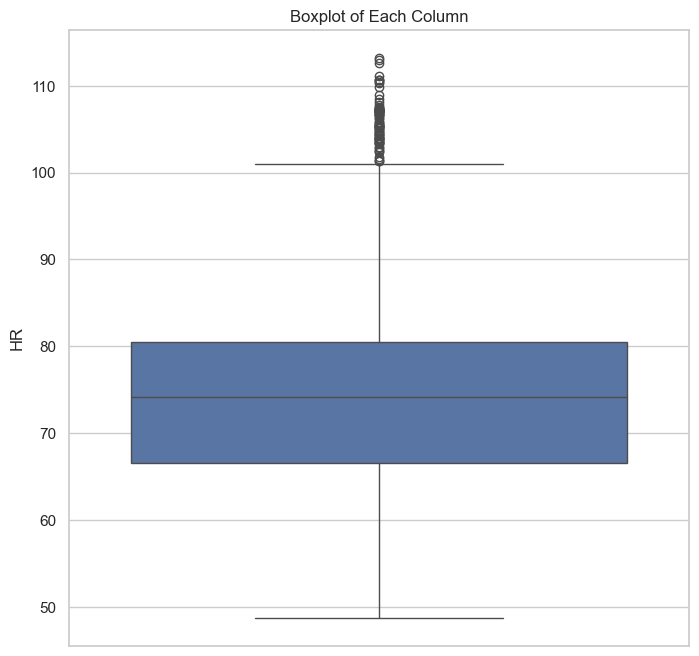

In [41]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
sns.boxplot(data=y, orient='v')
plt.xticks(rotation=90)
plt.title('Boxplot of Each Column')
plt.show()

You can see there are outliers in the target column but, we dont remove them , as humans can have heart rate greater than usual( >100) , so we dont remove them. I can say that very much people whose heart rate is determined are patients. Useful Infomation.

In [42]:
test1=test1[df_new1.columns]

In [43]:
test1.columns

Index(['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'LF_HF',
       'SD2', 'sampen', 'higuci', 'condition', 'MEAN_RR', 'pNN50', 'KURT',
       'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_RMSSD_REL_RR'],
      dtype='object')

# Importing Necessary Libraries

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# StandardScaler

In [45]:
scaler=StandardScaler()
X1=scaler.fit_transform(df_new1)
test1=scaler.transform(test1)

In [46]:
scaler_params=[scaler.mean_,scaler.var_]

# Train Test Split

In [47]:
X_train,X_test,y_train,y_test=train_test_split(X1,y,test_size=0.2,random_state=42)

# Decision Tree

In [48]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(random_state=0)
dec_tree.fit(X_train,y_train)
dec_tree_y_pred = dec_tree.predict(X_test)
print("Accuracy: {}".format(dec_tree.score(X_test,y_test)))
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=dec_tree_y_pred)))

Accuracy: 0.9965361458905129
R squared: 0.9965361458905129


In [49]:

dec_tree.score(test1,y_true)

0.9906922831280898

# Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_tree = RandomForestRegressor(random_state=0)
rf_tree.fit(X_train,y_train)
rf_tree_y_pred = rf_tree.predict(X_test)
print("Accuracy: {}".format(rf_tree.score(X_test,y_test)))
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=rf_tree_y_pred)))

Accuracy: 0.9988773982616372
R squared: 0.9988773982616372


In [51]:
rf_tree.score(test1,y_true)

0.9971248064861352

# Support Vector Machine

In [52]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train,y_train)
svr_y_pred = svr.predict(X_test)
print("Accuracy: {}".format(svr.score(X_test,y_test)))
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=svr_y_pred)))

Accuracy: 0.963901328198551
R squared: 0.963901328198551


In [53]:
svr.score(test1,y_true)

0.9950329366098524

# GradientBoosting

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor()
gbr.fit(X_train,y_train)
gbr_y_pred = gbr.predict(X_test)
print("Accuracy: {}".format(gbr.score(X_test,y_test)))

Accuracy: 0.9980654442704989


In [55]:
gbr.score(test1,y_true)

0.9934383795542059

# XGBoost Regressor

In [56]:
from xgboost import XGBRegressor
xgbr=XGBRegressor()
xgbr.fit(X_train,y_train)
xgbr_y_pred = xgbr.predict(X_test)
print("Accuracy: {}".format(xgbr.score(X_test,y_test)))

Accuracy: 0.99887927998359


In [57]:
xgbr_pred=xgbr.predict(test1)

In [58]:
print("Accuracy: {}".format(xgbr.score(test1,y_true)))

Accuracy: 0.9992828089788617


# Linear Regression

In [59]:

lr=LinearRegression()
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=lr_pred)))

R squared: 0.9763005772194225


In [60]:
lr_pred1=lr.predict(test1)
print("R squared: {}".format(r2_score(y_true=y_true,y_pred=lr_pred1)))

R squared: 0.9598657865349622


After seeing the performance of the each regressor , I am decided to use the ensemble of the model.The reason which would be like some base models, like Random Forest, Support Vector ,XGBoost, and Decision Tree, are effective at capturing nonlinear relationships as well as linear relationships and they all are also non-sensitive to outliers, while others, like Linear Regression, may perform better in capturing linear relationships but sensitive to outliers.As We all know ,in this case outliers are important. The ensemble can adapt to different types of relationships in the data as well as in the outliers.

# Voting Regressor

In [61]:
from sklearn.ensemble import VotingRegressor
voting_reg = VotingRegressor(estimators=[('XGBoost', xgbr),  ('svr', svr), ('dct', dec_tree), ('rf', rf_tree)],
                             n_jobs=5)
 
# Fit the Voting Regressor on the training data
voting_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('svr', SVR()),
                            ('dct', DecisionTreeRegressor(random_state=0)),
                            ('rf', RandomForestRegressor(random_state=0))],
                n_jobs=5)

In [62]:
voting_reg.score(X_test,y_test)
voting_reg.score(test1,y_true)

0.9975959738698421

In [63]:
testing=pd.DataFrame({'predictions':voting_reg.predict(X_test),'actual':y_test})

**Comparison of the predictions of the different models on the test data** 

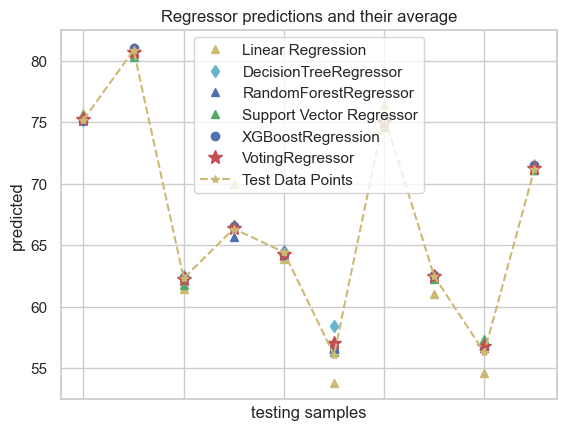

In [64]:
svr_pred=svr.predict(test1)
dec_tree_pred=dec_tree.predict(test1)
rf_tree_pred=rf_tree.predict(test1)
voting_reg_pred=voting_reg.predict(test1)
plt.figure()
plt.plot(lr_pred1,'y^',label="Linear Regression")
plt.plot(dec_tree_pred, "dc", label="DecisionTreeRegressor")
plt.plot(rf_tree_pred, "b^", label="RandomForestRegressor")
plt.plot(svr_pred, "g^", label="Support Vector Regressor")
plt.plot(xgbr_pred, "bo", label="XGBoostRegression")
 
plt.plot(voting_reg_pred, "r*", ms=10, label="VotingRegressor")
plt.plot( y_true,"y*--", label = 'Test Data Points')
 
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("testing samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")
 
plt.show()

In [65]:
results=pd.DataFrame({'predictions':voting_reg_pred,'actuals':y_true})
results

,predictions,actuals
0,75.296309,75.206050
1,80.744938,80.870132
2,62.242087,62.313063
3,66.366923,66.336924
4,64.315921,64.422596
5,57.028245,56.061095
6,75.045416,75.543673
7,62.453680,62.458281
8,56.819444,56.271876
9,71.237896,71.201501


Though the model is good , As we have some outliers , it can be possible that we have some chances that our model will not work on the outliers, lets see the predictions vs actuals plot for X_test

<Axes: xlabel='predictions', ylabel='actual'>

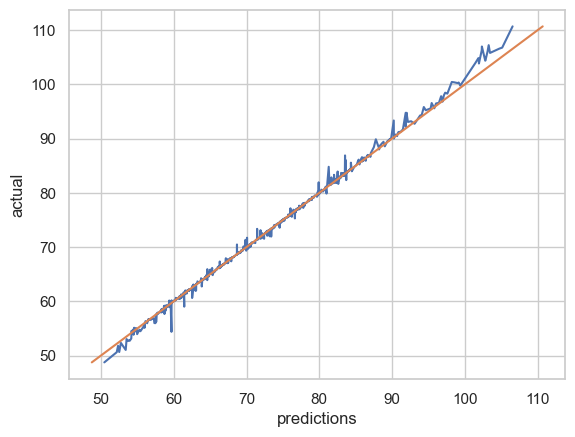

In [66]:
sns.lineplot(testing,x=testing['predictions'],y=testing['actual'])
sns.lineplot(testing,x=testing['actual'],y=testing['actual'])

You can see here that the cache here that , when the heart rate in the actually greater than 100 our model fails to predict , basically our model is not performing well with outliers.

In [67]:
len(train[train['HR']>=100])

96

# Final Model


I am going to store the final model as voting regresssor , the reference columns,the conditioning function used for transforming the *Condition* column to numerical column  the scaler parameters and the label as finalized_model.sav

In [68]:
# import joblib

In [69]:
# filename = 'finalized_model.pkl'
# joblib.dump((voting_reg,variables,condition_mapping_function,scaler_params), filename)

In [70]:
import pickle

In [ ]:
with open ('voting_reg.pkl','wb') as file:
    pickle.dump(voting_reg,file)

In [ ]:
results=pd.DataFrame({'predictions':voting_reg_pred,'actuals':y_true})
results